In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 📌 파일 경로 설정
train_path = "C:/Hackerton/train.csv"

# 데이터 로드
df = pd.read_csv(train_path)

# --------------------------------------- 결측치 처리를 위한 시술 ---------------------------------------------------
# 📌 Label Encoding을 위한 객체 생성
le_surgery_code = LabelEncoder()
le_age_group = LabelEncoder()
le = LabelEncoder()

df["시술 유형"] = le.fit_transform(df["시술 유형"])

# --------------------------------------- 결측치 처리 ---------------------------------------------------
# 특정 시술 유형이 NaN인 행 삭제
df = df.dropna(subset=["특정 시술 유형"])

# 난자 채취, 배아 이식, 난자 해동 등 관련 변수들
embryo_timing_columns = [
    "난자 채취 경과일", "난자 해동 경과일", "난자 혼합 경과일",
    "배아 이식 경과일", "배아 해동 경과일", "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부",
    "배아 생성 주요 이유", "총 생성 배아 수", "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수", "이식된 배아 수", "미세주입 배아 이식 수",
    "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수",
    "해동 난자 수", "수집된 신선 난자 수", "저장된 신선 난자 수",
    "혼합된 난자 수", "파트너 정자와 혼합된 난자 수", "기증자 정자와 혼합된 난자 수",
    "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부",
    "대리모 여부"
]

# 📌 DI를 시행한 경우 (시술 유형 == 1) 해당 변수들의 결측값을 -1로 채우기
df.loc[df["시술 유형"] == 0, embryo_timing_columns] = df.loc[df["시술 유형"] == 0, embryo_timing_columns].fillna(-1)

# 결측값을 0으로 처리할 변수들
columns_to_fill = [
    "착상 전 유전 검사 사용 여부", "PGD 시술 여부", "PGS 시술 여부" , "착상 전 유전 진단 사용 여부"
]

# 결측값을 0으로 채우기
df[columns_to_fill] = df[columns_to_fill].fillna(0)


# 결측값을 -1으로 처리할 변수들
columns_to_fill = [
    "난자 채취 경과일", "배아 이식 경과일", "난자 혼합 경과일" , "특정 시술 유형" 
]

# 결측값을 -1으로 채우기
df[columns_to_fill] = df[columns_to_fill].fillna(-1)


# 결측값을 0으로 처리할 변수들(보류 -1로 비교할 예정)
columns_to_fill = [
    "임신 시도 또는 마지막 임신 경과 연수", "난자 해동 경과일", "배아 해동 경과일"
]

# 결측값을 0으로 채우기
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# 각 변수별 결측값 개수 출력
missing_values = df.isnull().sum()

# 결측값이 있는 변수만 출력
print(missing_values[missing_values > 0])

# ------------------------------------------ 결측치 처리 ---------------------------------------------------
# "알 수 없음"을 -1로 변경할 컬럼 리스트
columns_to_replace = ["시술 당시 나이", "난자 출처", "난자 기증자 나이", "정자 기증자 나이", "배란 유도 유형", "배아 생성 주요 이유"]

for col in columns_to_replace:
    df[col] = df[col].replace("알 수 없음", -1)

# 레이블 인코딩을 적용할 컬럼 리스트
label_encode_columns = "시술 시기 코드", "시술 당시 나이", "배란 유도 유형", "총 시술 횟수", "클리닉 내 총 시술 횟수", "IVF 시술 횟수", "DI 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "DI 임신 횟수", "총 출산 횟수", "IVF 출산 횟수", "DI 출산 횟수", "기증자 정자와 혼합된 난자 수", "난자 출처", "정자 출처", "난자 기증자 나이", "정자 기증자 나이"

# 컬럼별로 LabelEncoder 생성 및 적용
label_encoders = {}  # 각 컬럼별 LabelEncoder 저장용

for col in label_encode_columns:    
    le = LabelEncoder()
    # -1이 아닌 값들만 학습
    unique_values = df.loc[df[col] != -1, col].unique()
    le.fit(unique_values)

    # Label Encoding 적용 (단, -1 값은 그대로 유지)
    df[col] = df[col].apply(lambda x: -1 if x == -1 else le.transform([x])[0])

# 📌 "배아 생성 주요 이유" 원-핫 인코딩 (복수 선택 가능)
df["배아 생성 주요 이유"] = df["배아 생성 주요 이유"].astype(str).apply(lambda x: x.split(',') if x != "-1" else [])

# 개별 요소를 원-핫 인코딩으로 변환
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_배아생성 = mlb.fit_transform(df["배아 생성 주요 이유"])
encoded_배아생성_df = pd.DataFrame(encoded_배아생성, columns=[f"배아 생성 주요 이유_{c}" for c in mlb.classes_])

# 기존 "배아 생성 주요 이유" 컬럼 제거 후 원-핫 인코딩한 값 추가
df = df.drop("배아 생성 주요 이유", axis=1)
df = pd.concat([df, encoded_배아생성_df], axis=1)


# 📌 특정 시술 유형 (유효한 값 목록)
valid_treatments = {"IVF", "IUI", "FER", "IVI", "BLASTOCYST", "AH", "GIFT", "ICI", "Generic DI", "ICSI", "Unknown"}

# 📌 유효한 값은 원-핫 인코딩 수행
for treatment in valid_treatments:
    df[f"특정 시술 - {treatment}"] = (df["특정 시술 유형"] == treatment).astype(int)

# 📌 "MIXED"에 해당하는 값만 추출
mixed_values = df[~df["특정 시술 유형"].isin(valid_treatments)]["특정 시술 유형"]

# 📌 "MIXED" 값만 레이블 인코딩 수행
label_encoder = LabelEncoder()
df["특정 시술 - MIXED"] = 0  # 기본값 0으로 초기화

if not mixed_values.empty:
    train_encoded = label_encoder.fit_transform(mixed_values) + 1  # 1부터 시작
    df.loc[~df["특정 시술 유형"].isin(valid_treatments), "특정 시술 - MIXED"] = train_encoded

# 📌 원본 컬럼 삭제
df.drop(columns=["특정 시술 유형"], inplace=True)


# 📌 CSV 파일 저장 경로 설정
csv_file_path = "C:/Hackerton/train_fifi.csv"

# 📌 CSV 파일로 저장
df.to_csv(csv_file_path, index=False)

C:\Users\pung\AppData\Local\Temp\ipykernel_11752\1849324447.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[df["시술 유형"] == 0, embryo_timing_columns] = df.loc[df["시술 유형"] == 0, embryo_timing_columns].fillna(-1)


Series([], dtype: int64)



KeyboardInterrupt



In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import numpy as np

# 📌 파일 경로 설정
train_path = "C:/Hackerton/train.csv"
test_path = "C:/Hackerton/test.csv"

# 데이터 로드
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 📌 Label Encoding을 위한 객체 생성
label_encoders = {}
mlb = MultiLabelBinarizer()

# 📌 시술 유형 인코딩
le_surgery_type = LabelEncoder()
train_df["시술 유형"] = le_surgery_type.fit_transform(train_df["시술 유형"].astype(str))
test_df["시술 유형"] = le_surgery_type.transform(test_df["시술 유형"].astype(str))

# 특정 시술 유형이 NaN인 행 삭제
train_df = train_df.dropna(subset=["특정 시술 유형"])


# 📌 결측치 처리
columns_to_fill_0 = [
    "난자 채취 경과일", "난자 해동 경과일", "난자 혼합 경과일",
    "배아 이식 경과일", "배아 해동 경과일", "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부",
    "배아 생성 주요 이유", "총 생성 배아 수", "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수", "이식된 배아 수", "미세주입 배아 이식 수",
    "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수",
    "해동 난자 수", "수집된 신선 난자 수", "저장된 신선 난자 수",
    "혼합된 난자 수", "파트너 정자와 혼합된 난자 수", "기증자 정자와 혼합된 난자 수",
    "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부",
    "대리모 여부"
]
# 📌 DI를 시행한 경우 (시술 유형 == 0) 해당 변수들의 결측값을 -1로 채우기
# train_df에서 '시술 유형'이 0인 경우만 결측값을 -1로 채움
train_df.loc[train_df["시술 유형"] == 0, columns_to_fill_0] = train_df.loc[train_df["시술 유형"] == 0, columns_to_fill_0].fillna(-1)

# test_df에서도 '시술 유형'이 0인 경우만 따로 처리
test_df.loc[test_df["시술 유형"] == 0, columns_to_fill_0] = test_df.loc[test_df["시술 유형"] == 0, columns_to_fill_0].fillna(-1)


columns_to_fill_minus1 = [
    "난자 채취 경과일", "배아 이식 경과일", "난자 혼합 경과일" , "특정 시술 유형" 
]
train_df[columns_to_fill_minus1] = train_df[columns_to_fill_minus1].fillna(-1)
test_df[columns_to_fill_minus1] = test_df[columns_to_fill_minus1].fillna(-1)

columns_to_fill_zero = [
    "착상 전 유전 검사 사용 여부", "PGD 시술 여부", "PGS 시술 여부" , "착상 전 유전 진단 사용 여부", "임신 시도 또는 마지막 임신 경과 연수", "난자 해동 경과일", "배아 해동 경과일"
]
train_df[columns_to_fill_zero] = train_df[columns_to_fill_zero].fillna(0)
test_df[columns_to_fill_zero] = test_df[columns_to_fill_zero].fillna(0)

# 각 변수별 결측값 개수 출력
missing_values = train_df.isnull().sum()

# 결측값이 있는 변수만 출력
print(missing_values[missing_values > 0])

# 각 변수별 결측값 개수 출력
missing_values2 = test_df.isnull().sum()

# 결측값이 있는 변수만 출력
print(missing_values2[missing_values2 > 0])

# 📌 "알 수 없음"을 -1로 변경할 컬럼 리스트
columns_to_replace = ["시술 당시 나이", "난자 출처", "난자 기증자 나이", "정자 기증자 나이", "배란 유도 유형", "배아 생성 주요 이유"]
for col in columns_to_replace:
    train_df[col] = train_df[col].replace("알 수 없음", -1)
    test_df[col] = test_df[col].replace("알 수 없음", -1)

# 📌 레이블 인코딩 적용할 컬럼 리스트
label_encode_columns = [
    "시술 시기 코드", "시술 당시 나이", "배란 유도 유형", "총 시술 횟수", "클리닉 내 총 시술 횟수", 
    "IVF 시술 횟수", "DI 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "DI 임신 횟수", "총 출산 횟수", 
    "IVF 출산 횟수", "DI 출산 횟수", "기증자 정자와 혼합된 난자 수", "난자 출처", "정자 출처", "난자 기증자 나이", "정자 기증자 나이"
]

for col in label_encode_columns:    
    le = LabelEncoder()
    unique_values = train_df.loc[train_df[col] != -1, col].unique()
    le.fit(unique_values)
    
    train_df[col] = train_df[col].apply(lambda x: -1 if x == -1 else le.transform([x])[0])
    
    # test 데이터에서 학습된 LabelEncoder의 클래스에 없는 값이 있으면 -1로 변환
    test_df[col] = test_df[col].apply(lambda x: -1 if x == -1 or x not in le.classes_ else le.transform([x])[0])
    
    label_encoders[col] = le

# 📌 "배아 생성 주요 이유" 원-핫 인코딩 (-1 무시 추가)
train_df["배아 생성 주요 이유"] = train_df["배아 생성 주요 이유"].astype(str).apply(lambda x: x.split(',') if x not in ["-1", "nan"] else [])
test_df["배아 생성 주요 이유"] = test_df["배아 생성 주요 이유"].astype(str).apply(lambda x: x.split(',') if x not in ["-1", "nan"] else [])

mlb.fit(train_df["배아 생성 주요 이유"])
train_encoded = mlb.transform(train_df["배아 생성 주요 이유"])
test_encoded = mlb.transform(test_df["배아 생성 주요 이유"])

train_encoded_df = pd.DataFrame(train_encoded, columns=[f"배아 생성 주요 이유_{c}" for c in mlb.classes_])
test_encoded_df = pd.DataFrame(test_encoded, columns=[f"배아 생성 주요 이유_{c}" for c in mlb.classes_])

train_df = train_df.drop("배아 생성 주요 이유", axis=1)
test_df = test_df.drop("배아 생성 주요 이유", axis=1)
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)


# 특정 시술 유형 (유효한 값 목록)
valid_treatments = {"IVF", "IUI", "FER", "IVI", "BLASTOCYST", "AH", "GIFT", "ICI", "Generic DI", "ICSI", "Unknown"}

# 원-핫 인코딩 적용
for treatment in valid_treatments:
    train_df[f"특정 시술 - {treatment}"] = (train_df["특정 시술 유형"] == treatment).astype(int)
    test_df[f"특정 시술 - {treatment}"] = (test_df["특정 시술 유형"] == treatment).astype(int)

# MIXED 처리 (라벨 인코딩 적용)
label_encoder = LabelEncoder()

# "MIXED"가 포함된 경우만 추출
train_mixed_values = train_df.loc[~train_df["특정 시술 유형"].isin(valid_treatments), "특정 시술 유형"]
test_mixed_values = test_df.loc[~test_df["특정 시술 유형"].isin(valid_treatments), "특정 시술 유형"]

# train 데이터에서 LabelEncoder 학습
if not train_mixed_values.empty:
    label_encoder.fit(train_mixed_values)
    
    # UNKNOWN 처리
    if "UNKNOWN" not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_, "UNKNOWN")
    
    # train에 적용
    train_df["특정 시술 - MIXED"] = 0  # 기본값 0
    train_df.loc[~train_df["특정 시술 유형"].isin(valid_treatments), "특정 시술 - MIXED"] = label_encoder.transform(train_mixed_values) + 1  # 1부터 시작
    
    # test에 동일한 인코딩 적용
    test_df["특정 시술 - MIXED"] = 0  # 기본값 0
    if not test_mixed_values.empty:
        # 학습되지 않은 새로운 값은 "UNKNOWN"으로 처리
        test_mixed_values_filtered = [val if val in label_encoder.classes_ else "UNKNOWN" for val in test_mixed_values]
        test_df.loc[~test_df["특정 시술 유형"].isin(valid_treatments), "특정 시술 - MIXED"] = label_encoder.transform(test_mixed_values_filtered) + 1

# 📌 원본 컬럼 삭제
train_df.drop(columns=["특정 시술 유형"], inplace=True)
test_df.drop(columns=["특정 시술 유형"], inplace=True)

# 📌 CSV 파일 저장
train_csv_file_path = "C:/Hackerton/train_fifi.csv"
test_csv_file_path = "C:/Hackerton/test_fifi.csv"
train_df.to_csv(train_csv_file_path, index=False)
test_df.to_csv(test_csv_file_path, index=False)

C:\Users\pung\AppData\Local\Temp\ipykernel_22356\2096538757.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.loc[train_df["시술 유형"] == 0, columns_to_fill_0] = train_df.loc[train_df["시술 유형"] == 0, columns_to_fill_0].fillna(-1)
C:\Users\pung\AppData\Local\Temp\ipykernel_22356\2096538757.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df.loc[test_df["시술 유형"] == 0, columns_to_fill_0] = test_df.loc[test_df["시술 유형"] == 0, columns_to_fill_0].fillna(-1)


Series([], dtype: int64)
Series([], dtype: int64)


PermissionError: [Errno 13] Permission denied: 'C:/Hackerton/train_fifi.csv'

In [4]:
# 📌 CSV 파일 저장
train_csv_file_path = "C:/Hackerton/train_fifi.csv"
test_csv_file_path = "C:/Hackerton/test_fifi.csv"
train_df.to_csv(train_csv_file_path, index=False)
test_df.to_csv(test_csv_file_path, index=False)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 📌 데이터 파일 경로 설정
train_path = "C:/Hackerton/train_cleaned.csv"
test_path = "C:/Hackerton/test_cleaned.csv"
submission_path = "C:/Hackerton/sample_submission.csv"

# 📌 데이터 로드 (ID 컬럼 유지)
train_df = pd.read_csv(train_path, encoding="utf-8-sig")
test_df = pd.read_csv(test_path, encoding="utf-8-sig")

# 📌 ID 컬럼 따로 저장 (Test 데이터)
test_ids = test_df.iloc[:, 0]  # 첫 번째 열을 ID로 저장
test_df = test_df.iloc[:, 1:]  # ID 제외한 나머지 데이터 사용

# 📌 종속 변수 설정 (임신 성공 여부)
target_col = "임신 성공 여부"

# 📌 Feature Selection (논문 기반 주요 변수 선택)
selected_features = [
    "시술 당시 나이", "총 생성 배아 수", "미세주입된 난자 수",
    "이식된 배아 수", "미세주입 배아 이식 수", "배란 자극 여부",
    "난자 채취 경과일", "배아 이식 경과일", "정자 출처"
]

# 📌 Feature Engineering (새로운 변수 생성)
train_df["IVF 성공률"] = train_df["이식된 배아 수"] / (train_df["총 생성 배아 수"] + 1)
test_df["IVF 성공률"] = test_df["이식된 배아 수"] / (test_df["총 생성 배아 수"] + 1)

# 🔹 **무한대 (inf) 값 또는 NaN이 발생할 가능성이 있는지 체크**
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 🔹 **NaN 값이 있다면 0으로 대체**
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

# 📌 나이 그룹 생성 (-1, 0, 1로 변환)
train_df["나이 그룹"] = train_df["시술 당시 나이"].apply(lambda x: -1 if x == -1 else (0 if x == 0 else 1))
test_df["나이 그룹"] = test_df["시술 당시 나이"].apply(lambda x: -1 if x == -1 else (0 if x == 0 else 1))

# 선택된 변수 리스트에 추가
selected_features.append("나이 그룹")
selected_features.append("IVF 성공률")

# 📌 독립 변수(X)와 종속 변수(y) 분리
X = train_df[selected_features]
y = train_df[target_col]

# 📌 데이터 불균형 해결 (논문 방식 - SMOTE 적용)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"✅ 데이터 균형 조정 후 클래스 분포:\n{y_resampled.value_counts()}")

# 📌 Train/Test 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# 📌 XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)

# 📌 하이퍼파라미터 튜닝 (GridSearchCV 적용)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 모델 선정
best_xgb = grid_search.best_estimator_
print(f"\n✅ 최적의 하이퍼파라미터: {grid_search.best_params_}")

# 📌 검증 데이터 평가
y_val_pred = best_xgb.predict(X_val)

# 📌 컨퓨전 매트릭스 생성 및 성능 평가
conf_matrix = confusion_matrix(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

# 📌 결과 출력
print(f"\n✅ XGBoost 모델 정확도: {accuracy:.4f}")
print("\n✅ 분류 보고서:")
print(report)

# 📌 컨퓨전 매트릭스 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["실패", "성공"], yticklabels=["실패", "성공"])
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# 📌 Feature Importance 시각화
feature_importance = best_xgb.feature_importances_
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df[:10])  # 상위 10개만 표시
plt.title("XGBoost Feature Importance")
plt.show()

# 📌 Test 데이터 예측
X_test = test_df[selected_features]
y_test_pred = best_xgb.predict(X_test)

# 📌 예측 결과를 DataFrame으로 변환
submission_df = pd.DataFrame({"ID": test_ids, "임신 성공 여부": y_test_pred})

# 📌 예측 결과 저장
submission_df.to_csv(submission_path, index=False, encoding="utf-8-sig")

print(f"\n✅ 예측 완료! 결과 저장: {submission_path}")

✅ 데이터 균형 조정 후 클래스 분포:
임신 성공 여부
0    190123
1    190123
Name: count, dtype: int64


KeyboardInterrupt: 

In [81]:
import scipy.stats as stats
import pandas as pd

# IVF(0) vs DI(1) 그룹의 성공/실패 빈도 테이블 생성
contingency_table = pd.crosstab(df["시술 유형"], df["임신 성공 여부"])

# 카이제곱 검정 실행
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# 결과 출력
print(f"카이제곱 통계량: {chi2:.4f}")
print(f"p-value: {p:.4f}")

# p-value < 0.05이면 유의미한 차이가 있음!
if p < 0.05:
    print("✅ IVF와 DI 간의 임신 성공률 차이가 통계적으로 유의미함!")
else:
    print("❌ IVF와 DI 간의 차이가 유의미하지 않음. 단순한 우연일 가능성 있음.")

카이제곱 통계량: 563.2113
p-value: 0.0000
✅ IVF와 DI 간의 임신 성공률 차이가 통계적으로 유의미함!


In [ ]:
# 배아 관련 변수 목록 (결측값 6291개인 변수들)
embryo_related_columns = [
    "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부",
    "배아 생성 주요 이유", "총 생성 배아 수", "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수", "이식된 배아 수", "미세주입 배아 이식 수",
    "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수",
    "해동 난자 수", "수집된 신선 난자 수", "저장된 신선 난자 수",
    "혼합된 난자 수", "파트너 정자와 혼합된 난자 수", "기증자 정자와 혼합된 난자 수",
    "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부",
    "대리모 여부"
]

# 📌 "시술 유형"이 1 (DI 시술을 받은 경우) & 해당 변수가 결측값(NaN)인 경우만 -1로 변경
df.loc[(df["시술 유형"] == 1) & (df[embryo_related_columns].isnull()), embryo_related_columns] = -1

# 📌 결과 확인 (모든 결측값이 0인지 확인)
print(df[embryo_related_columns].isnull().sum())  # 모든 결측값이 0이어야 함

C:\Users\pung\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ 최적의 하이퍼파라미터: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}


C:\Users\pung\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Report:
              precision    recall  f1-score   support

         0.0       0.72      0.56      0.63     13299
         1.0       0.64      0.79      0.70     13192

    accuracy                           0.67     26491
   macro avg       0.68      0.67      0.67     26491
weighted avg       0.68      0.67      0.67     26491



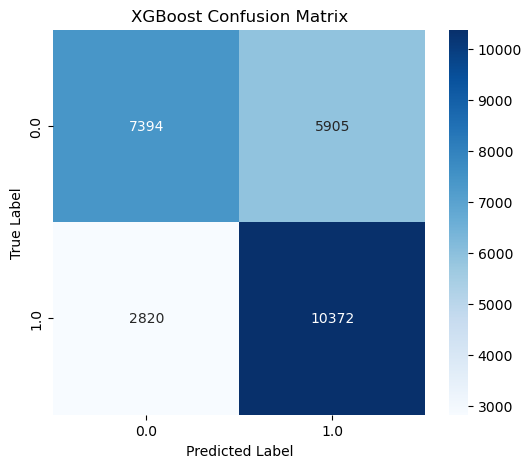

✅ 제출 파일 저장 완료: C:/Hackerton/sample_submission5.csv


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# CSV 파일 읽기
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# ID 컬럼 저장 및 제거
test_ids = test_df.iloc[:, 0]
test_df = test_df.iloc[:, 1:]

# 결측치 제거
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# 종속변수 설정
target_variable = "임신 성공 여부"

# 상관관계 계산
correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix[target_variable].drop(target_variable)


# 특성과 라벨 분리
X = train_df[significant_correlation.index]
y = train_df[target_variable]

# 클래스 비율 확인
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

# 언더샘플링 적용 (다수 클래스가 소수 클래스보다 1.5배 많도록 조정)
sampling_ratio = 1  # 다수 클래스가 소수 클래스보다 1.5배 많도록 조정
target_minority_count = class_counts[minority_class]
target_majority_count = int(target_minority_count * sampling_ratio)

rus = RandomUnderSampler(sampling_strategy={majority_class: target_majority_count, minority_class: target_minority_count}, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# XGBoost 하이퍼파라미터 검색 공간 정의
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# XGBoost 모델 생성
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# RandomizedSearchCV를 사용한 최적화
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1
)

# 하이퍼파라미터 튜닝 실행
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("✅ 최적의 하이퍼파라미터:", random_search.best_params_)

# 최적의 파라미터로 XGBoost 모델 재학습
best_xgb_model = XGBClassifier(**random_search.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train, y_train)

# 모델 예측
y_pred_xgb = best_xgb_model.predict(X_test)

# 컨퓨전 매트릭스 생성 및 시각화
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("XGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

# 📌 모델 예측 (최적화된 XGBoost 사용)
test_X = test_df[significant_correlation.index]
y_pred_test = best_xgb_model.predict(test_X)

# 📌 ID 컬럼 포함하여 저장
submission = pd.DataFrame({'ID': test_ids, 'probability': y_pred_test})
submission.to_csv(submission_file_path, index=False)

print(f"✅ 제출 파일 저장 완료: {submission_file_path}")

✅ 최적의 랜덤 포레스트 하이퍼파라미터: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Random Forest Classifier Report:
              precision    recall  f1-score   support

         0.0       0.70      0.75      0.73     19780
         1.0       0.59      0.53      0.56     13333

    accuracy                           0.66     33113
   macro avg       0.65      0.64      0.64     33113
weighted avg       0.66      0.66      0.66     33113



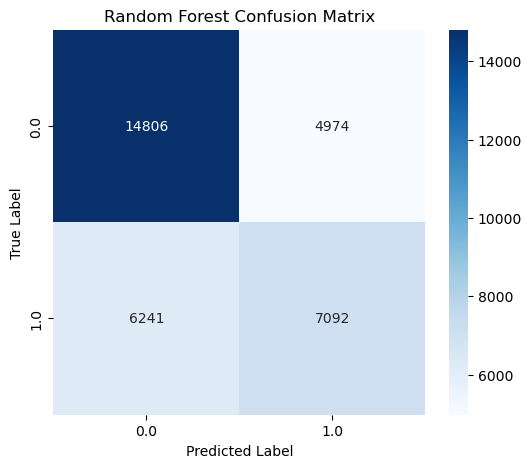

✅ 제출 파일 저장 완료: C:/Hackerton/sample_submission5.csv


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# CSV 파일 읽기
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# ID 컬럼 저장 및 제거
test_ids = test_df.iloc[:, 0]
test_df = test_df.iloc[:, 1:]

# 결측치 제거
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# 종속변수 설정
target_variable = "임신 성공 여부"

# 상관관계 계산
correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix[target_variable].drop(target_variable)

# 상관관계 높은 독립변수 추출 (절대값 기준으로 내림차순 정렬)
thresh = 0.05  # 유의한 상관계수 임계값 설정
significant_correlation = correlation_with_target[abs(correlation_with_target) > thresh].sort_values(ascending=False)

# 특성과 라벨 분리
X = train_df[significant_correlation.index]
y = train_df[target_variable]

# 클래스 비율 확인
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

# 언더샘플링 적용 (1.5:1 비율 유지)
sampling_ratio = 1.5
target_minority_count = class_counts[minority_class]
target_majority_count = int(target_minority_count * sampling_ratio)

rus = RandomUnderSampler(sampling_strategy={majority_class: target_majority_count, minority_class: target_minority_count}, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 랜덤 포레스트 하이퍼파라미터 검색 공간 정의
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV를 사용한 최적화
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, 
    n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1
)

# 하이퍼파라미터 튜닝 실행
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("✅ 최적의 랜덤 포레스트 하이퍼파라미터:", random_search.best_params_)

# 최적의 파라미터로 랜덤 포레스트 모델 재학습
best_rf_model = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

# 모델 예측
y_pred_rf = best_rf_model.predict(X_test)

# 컨퓨전 매트릭스 생성 및 시각화
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

# 📌 모델 예측 (최적화된 랜덤 포레스트 사용)
test_X = test_df[significant_correlation.index]
y_pred_test = best_rf_model.predict(test_X)

# 📌 ID 컬럼 포함하여 저장
submission = pd.DataFrame({'ID': test_ids, 'probability': y_pred_test})
submission.to_csv(submission_file_path, index=False)

print(f"✅ 제출 파일 저장 완료: {submission_file_path}")

C:\Users\pung\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ 최적의 하이퍼파라미터: {'subsample': 1.0, 'reg_lambda': 0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}


C:\Users\pung\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:13:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pung\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:13:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Report:
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75     38206
         1.0       0.75      0.74      0.75     37843

    accuracy                           0.75     76049
   macro avg       0.75      0.75      0.75     76049
weighted avg       0.75      0.75      0.75     76049



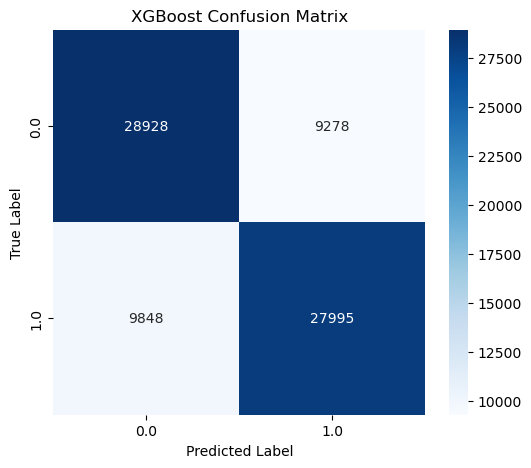

✅ 제출 파일 저장 완료: C:/Hackerton/sample_submission5.csv


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# CSV 파일 읽기
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# ID 컬럼 저장 및 제거
test_ids = test_df.iloc[:, 0]
test_df = test_df.iloc[:, 1:]

# 결측치 제거
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# 종속변수 설정
target_variable = "임신 성공 여부"

# 상관관계 계산
correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix[target_variable].drop(target_variable)

# 상관관계 높은 독립변수 추출 (절대값 기준으로 내림차순 정렬)
thresh = 0.05  
significant_correlation = correlation_with_target[abs(correlation_with_target) > thresh].sort_values(ascending=False)

# 특성과 라벨 분리
X = train_df[significant_correlation.index]
y = train_df[target_variable]

# SMOTE 적용 (다수 클래스가 소수 클래스보다 1.5배 많도록 조정)
smote = SMOTE(sampling_strategy=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# XGBoost 하이퍼파라미터 검색 공간 정의
param_dist = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 12],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'reg_lambda': [0, 0.1, 1, 10, 100]  # L2 Regularization 추가
}

# XGBoost 모델 생성
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# RandomizedSearchCV를 사용한 최적화
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1
)

# 하이퍼파라미터 튜닝 실행
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("✅ 최적의 하이퍼파라미터:", random_search.best_params_)

# 최적의 파라미터로 XGBoost 모델 재학습
best_xgb_model = XGBClassifier(
    **random_search.best_params_,
    use_label_encoder=False,
    eval_metric="logloss",  # ⬅ 여기에서 설정해야 함!
    enable_categorical=False,  # ⬅ 최신 XGBoost에서는 명시적으로 설정해야 함
    random_state=42
)

# Early Stopping 적용 없이 학습 (일단 fit을 실행)
best_xgb_model.fit(X_train, y_train, verbose=True)



# Feature Importance 확인 후 상위 변수 선택
importances = best_xgb_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]  
top_features = X.columns[sorted_idx[:10]]  

# 상위 중요 변수를 이용한 학습 데이터 생성
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# 최적 모델 재학습
best_xgb_model.fit(X_train_top, y_train)

# 모델 예측
y_pred_xgb = best_xgb_model.predict(X_test_top)

# 컨퓨전 매트릭스 생성 및 시각화
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("XGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

# 📌 모델 예측 (최적화된 XGBoost 사용)
test_X = test_df[significant_correlation.index]
test_X_top = test_X[top_features]  # 상위 중요 변수를 이용한 예측

y_pred_test = best_xgb_model.predict(test_X_top)

# 📌 ID 컬럼 포함하여 저장
submission = pd.DataFrame({'ID': test_ids, 'probability': y_pred_test})
submission.to_csv(submission_file_path, index=False)

print(f"✅ 제출 파일 저장 완료: {submission_file_path}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\pung\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🎯 최적 하이퍼파라미터: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.8}

IVF 모델 성능 보고서:
              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73     19531
         1.0       0.60      0.51      0.55     13177

    accuracy                           0.67     32708
   macro avg       0.65      0.64      0.64     32708
weighted avg       0.66      0.67      0.66     32708



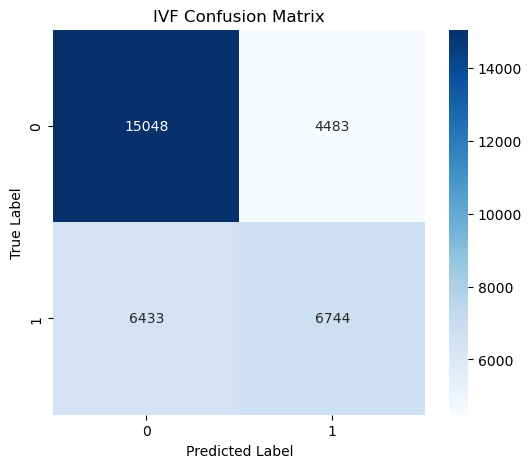

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\pung\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🎯 최적 하이퍼파라미터: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}

DI 모델 성능 보고서:
              precision    recall  f1-score   support

         0.0       0.65      0.83      0.73       244
         1.0       0.57      0.34      0.42       162

    accuracy                           0.63       406
   macro avg       0.61      0.58      0.58       406
weighted avg       0.62      0.63      0.61       406



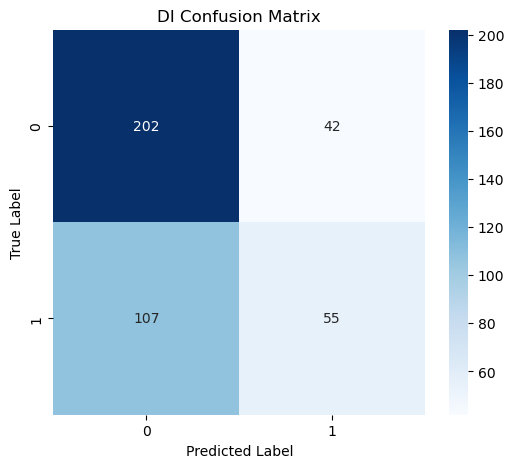

✅ 최종 제출 파일 저장 완료: C:/Hackerton/sample_submission5.csv


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# CSV 파일 읽기
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# ID 컬럼 저장
test_ids = test_df["ID"].copy()

# 결측치 제거
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# 종속변수 및 시술 유형 컬럼 설정
target_variable = "임신 성공 여부"
procedure_type = "시술 유형"

# IVF와 DI 데이터 분리
test_df_ivf = test_df[test_df[procedure_type] == 1].copy()
test_df_di = test_df[test_df[procedure_type] == 0].copy()
ivf_train = train_df[train_df[procedure_type] == 1].copy()
di_train = train_df[train_df[procedure_type] == 0].copy()

# IVF와 DI에서 사용할 변수 선택
ivf_features = [
    "시술 시기 코드", "시술 당시 나이", "배란 자극 여부", "배란 유도 유형", "단일 배아 이식 여부", 
    "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부", "총 생성 배아 수", 
    "미세주입된 난자 수", "미세주입에서 생성된 배아 수", "이식된 배아 수", 
    "미세주입 배아 이식 수", "저장된 배아 수", "미세주입 후 저장된 배아 수", 
    "해동된 배아 수", "해동 난자 수", "수집된 신선 난자 수", "저장된 신선 난자 수",
    "혼합된 난자 수", "파트너 정자와 혼합된 난자 수", "기증자 정자와 혼합된 난자 수",
    "총 시술 횟수", "클리닉 내 총 시술 횟수", "IVF 시술 횟수", 
    "총 임신 횟수", "IVF 임신 횟수", "총 출산 횟수", "IVF 출산 횟수",
    "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부", 
    "대리모 여부", "PGD 시술 여부", "PGS 시술 여부", 
    "난자 채취 경과일", "난자 해동 경과일", "배아 이식 경과일", "배아 해동 경과일",
    
    # 불임 원인 변수 추가
    "남성 주 불임 원인", "남성 부 불임 원인", "여성 주 불임 원인", "여성 부 불임 원인",
    "부부 주 불임 원인", "부부 부 불임 원인", "불명확 불임 원인",
    "불임 원인 - 난관 질환", "불임 원인 - 남성 요인", "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인", "불임 원인 - 자궁경부 문제", "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도", "불임 원인 - 정자 면역학적 요인", "불임 원인 - 정자 운동성", "불임 원인 - 정자 형태"
]


di_features = [
    "시술 시기 코드", "시술 당시 나이", "임신 시도 또는 마지막 임신 경과 연수",
    "난자 출처", "정자 출처", "난자 기증자 나이", "정자 기증자 나이",
    "총 시술 횟수", "클리닉 내 총 시술 횟수", "DI 시술 횟수",
    "총 임신 횟수", "DI 임신 횟수", "총 출산 횟수", "DI 출산 횟수",
    "배란 유도 유형", "난자 혼합 경과일",
    "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부",
    "대리모 여부", "PGD 시술 여부", "PGS 시술 여부",

    # 불임 원인 변수 추가
    "남성 주 불임 원인", "남성 부 불임 원인", "여성 주 불임 원인", "여성 부 불임 원인",
    "부부 주 불임 원인", "부부 부 불임 원인", "불명확 불임 원인",
    "불임 원인 - 난관 질환", "불임 원인 - 남성 요인", "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인", "불임 원인 - 자궁경부 문제", "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도", "불임 원인 - 정자 면역학적 요인", "불임 원인 - 정자 운동성", "불임 원인 - 정자 형태"
]



# IVF 데이터 준비
X_ivf = ivf_train[ivf_features]
y_ivf = ivf_train[target_variable]

# DI 데이터 준비
X_di = di_train[di_features]
y_di = di_train[target_variable]

# 클래스 비율 확인 및 언더샘플링 적용
def balance_data(X, y):
    if X.empty or y.empty:
        print("⚠️ 데이터가 비어 있어 언더샘플링을 건너뜁니다.")
        return X, y
    
    class_counts = y.value_counts()
    if len(class_counts) < 2:
        print("⚠️ 단일 클래스만 존재하여 언더샘플링을 건너뜁니다.")
        return X, y
    
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    target_minority_count = class_counts[minority_class]
    target_majority_count = int(target_minority_count * 1.5)
    
    rus = RandomUnderSampler(sampling_strategy={majority_class: target_majority_count, minority_class: target_minority_count}, random_state=42)
    return rus.fit_resample(X, y)

X_ivf_balanced, y_ivf_balanced = balance_data(X_ivf, y_ivf)
X_di_balanced, y_di_balanced = balance_data(X_di, y_di)

# 학습 및 테스트 데이터 분할
if not X_ivf_balanced.empty:
    X_ivf_train, X_ivf_test, y_ivf_train, y_ivf_test = train_test_split(X_ivf_balanced, y_ivf_balanced, test_size=0.2, random_state=42)
else:
    X_ivf_train = X_ivf_test = y_ivf_train = y_ivf_test = None

if not X_di_balanced.empty:
    X_di_train, X_di_test, y_di_train, y_di_test = train_test_split(X_di_balanced, y_di_balanced, test_size=0.2, random_state=42)
else:
    X_di_train = X_di_test = y_di_train = y_di_test = None

# XGBoost 하이퍼파라미터 튜닝
def tune_xgboost(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 5, 7, 9, 12],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3, 0.5],
        'reg_alpha': [0, 0.01, 0.1, 1, 10],
        'reg_lambda': [0, 0.01, 0.1, 1, 10]
    }

    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=xgb_model, 
        param_distributions=param_dist, 
        n_iter=20, 
        scoring='accuracy', 
        cv=3, 
        verbose=2, 
        n_jobs=-1, 
        random_state=42
    )
    
    random_search.fit(X_train, y_train)
    print(f"🎯 최적 하이퍼파라미터: {random_search.best_params_}")
    
    return random_search.best_estimator_

# 모델 평가 함수
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n{model_name} 모델 성능 보고서:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    return y_pred

# IVF 모델 학습 및 평가
if X_ivf_train is not None:
    best_ivf_model = tune_xgboost(X_ivf_train, y_ivf_train)
    y_ivf_pred = evaluate_model(best_ivf_model, X_ivf_test, y_ivf_test, "IVF")

# DI 모델 학습 및 평가
if X_di_train is not None:
    best_di_model = tune_xgboost(X_di_train, y_di_train)
    y_di_pred = evaluate_model(best_di_model, X_di_test, y_di_test, "DI")

# IVF와 DI 예측 결과 병합
test_df_ivf["probability"] = best_ivf_model.predict(test_df_ivf[ivf_features])
test_df_di["probability"] = best_di_model.predict(test_df_di[di_features])
submission = pd.concat([test_df_ivf[["ID", "probability"]], test_df_di[["ID", "probability"]]])
submission = submission.set_index("ID").reindex(test_ids).reset_index()

# 최종 결과 저장
submission.to_csv(submission_file_path, index=False)
print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
import optuna

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# 데이터 로드
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# 숫자형 데이터만 선택하여 결측치 처리
numeric_features = test_df.select_dtypes(include=[np.number]).columns

imputer = SimpleImputer(strategy="mean")
train_df[numeric_features] = imputer.fit_transform(train_df[numeric_features])
test_df[numeric_features] = imputer.transform(test_df[numeric_features])

# 새로운 Feature 생성 ('배아 이식 성공률')
# '배아 이식 성공률' 계산 시 0/0 방지
train_df["배아 이식 성공률"] = np.where(
    train_df["총 생성 배아 수"] > 0,
    train_df["이식된 배아 수"] / train_df["총 생성 배아 수"],
    0  # 분모가 0이면 0으로 처리
)

test_df["배아 이식 성공률"] = np.where(
    test_df["총 생성 배아 수"] > 0,
    test_df["이식된 배아 수"] / test_df["총 생성 배아 수"],
    0  # 분모가 0이면 0으로 처리
)

# 종속변수 및 시술 유형 컬럼
TARGET = "임신 성공 여부"
PROCEDURE_TYPE = "시술 유형"

# IVF와 DI 데이터 분리
train_ivf = train_df[train_df[PROCEDURE_TYPE] == 1].copy()
train_di = train_df[train_df[PROCEDURE_TYPE] == 0].copy()
test_ivf = test_df[test_df[PROCEDURE_TYPE] == 1].copy()
test_di = test_df[test_df[PROCEDURE_TYPE] == 0].copy()

# 사용 변수 정의 (IVF & DI Feature 선정)
ivf_features = [
    "시술 당시 나이", "배란 유도 유형", "총 생성 배아 수", "이식된 배아 수", "배아 이식 성공률",
    "난자 채취 경과일", "배아 이식 경과일", "배아 해동 경과일", "총 시술 횟수", "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "총 출산 횟수", "IVF 출산 횟수",
    "남성 주 불임 원인", "여성 주 불임 원인", "불명확 불임 원인", "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인", "불임 원인 - 배란 장애", "불임 원인 - 자궁내막증",
    "특정 시술 - ICSI", "특정 시술 - IVF", "특정 시술 - FER"
]

di_features = [
    "시술 당시 나이", "총 시술 횟수", "배란 유도 유형", "DI 시술 횟수", "임신 시도 또는 마지막 임신 경과 연수",
    "난자 출처", "정자 출처", "난자 기증자 나이", "정자 기증자 나이", "총 출산 횟수", "DI 출산 횟수",
    "남성 주 불임 원인", "여성 주 불임 원인", "불명확 불임 원인", "불임 원인 - 배란 장애",
    "특정 시술 - Generic DI", "특정 시술 - IUI"
]

X_ivf, y_ivf = train_ivf[ivf_features], train_ivf[TARGET]
X_di, y_di = train_di[di_features], train_di[TARGET]

# 1:1 비율로 테스트 데이터 분할
X_ivf_train, X_ivf_test, y_ivf_train, y_ivf_test = train_test_split(
    X_ivf, y_ivf, test_size=0.2, stratify=y_ivf, random_state=42
)
X_di_train, X_di_test, y_di_train, y_di_test = train_test_split(
    X_di, y_di, test_size=0.2, stratify=y_di, random_state=42
)

# SMOTE 적용 (학습 데이터 증강)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_ivf_train_resampled, y_ivf_train_resampled = smote.fit_resample(X_ivf_train, y_ivf_train)
X_di_train_resampled, y_di_train_resampled = smote.fit_resample(X_di_train, y_di_train)

# Optuna 하이퍼파라미터 튜닝 (IVF)
def objective_ivf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }
    model = xgb.XGBClassifier(eval_metric="logloss", **params)
    model.fit(X_ivf_train_resampled, y_ivf_train_resampled)
    return model.score(X_ivf_test, y_ivf_test)

study_ivf = optuna.create_study(direction="maximize")
study_ivf.optimize(objective_ivf, n_trials=50)
best_params_ivf = study_ivf.best_params

# Optuna 하이퍼파라미터 튜닝 (DI)
def objective_di(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }
    model = xgb.XGBClassifier(eval_metric="logloss", **params)
    model.fit(X_di_train_resampled, y_di_train_resampled)
    return model.score(X_di_test, y_di_test)

study_di = optuna.create_study(direction="maximize")
study_di.optimize(objective_di, n_trials=50)
best_params_di = study_di.best_params

# IVF & DI 예측 모델 적용
test_ivf["probability"] = xgb.XGBClassifier(eval_metric="logloss", **best_params_ivf).fit(X_ivf_train_resampled, y_ivf_train_resampled).predict(test_ivf[ivf_features])
test_di["probability"] = xgb.XGBClassifier(eval_metric="logloss", **best_params_di).fit(X_di_train_resampled, y_di_train_resampled).predict(test_di[di_features])

# 최종 제출 파일 저장
submission = pd.concat([test_ivf[["ID", "probability"]], test_di[["ID", "probability"]]])
submission.to_csv(submission_file_path, index=False)
print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")


[I 2025-02-16 18:18:01,103] A new study created in memory with name: no-name-644d3294-9d78-4b40-9b8e-a0c69ff86d0f
[I 2025-02-16 18:18:07,881] Trial 0 finished with value: 0.6791370071182916 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.037800447990365096, 'subsample': 0.605676586654399, 'colsample_bytree': 0.8728515689343056}. Best is trial 0 with value: 0.6791370071182916.
[I 2025-02-16 18:18:09,743] Trial 1 finished with value: 0.6265696232904103 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.013468617667910366, 'subsample': 0.9858479815267598, 'colsample_bytree': 0.8179325956643049}. Best is trial 0 with value: 0.6791370071182916.
[I 2025-02-16 18:18:20,764] Trial 2 finished with value: 0.6817963688714709 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.07771779282701259, 'subsample': 0.6212987217641327, 'colsample_bytree': 0.6974166787712317}. Best is trial 2 with value: 0.6817963688714709.
[I 2025-02-16

✅ 최종 제출 파일 저장 완료: C:/Hackerton/sample_submission5.csv


✅ IVF 모델 평가
정확도: 0.6247
분류 보고서:
               precision    recall  f1-score   support

         0.0       0.60      0.75      0.67     13084
         1.0       0.67      0.50      0.57     13084

    accuracy                           0.62     26168
   macro avg       0.63      0.62      0.62     26168
weighted avg       0.63      0.62      0.62     26168



C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

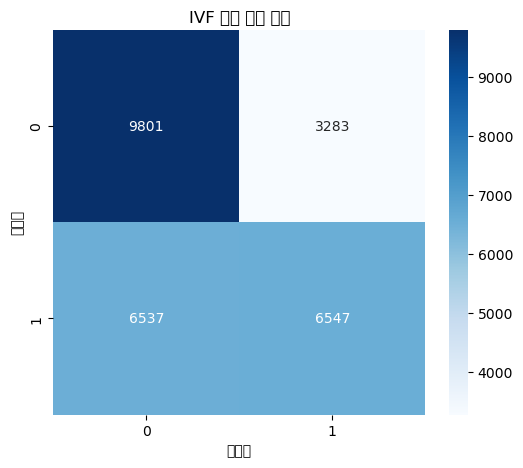

✅ DI 모델 평가
정확도: 0.5525
분류 보고서:
               precision    recall  f1-score   support

         0.0       0.53      0.93      0.68       162
         1.0       0.72      0.17      0.28       162

    accuracy                           0.55       324
   macro avg       0.62      0.55      0.48       324
weighted avg       0.62      0.55      0.48       324



C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

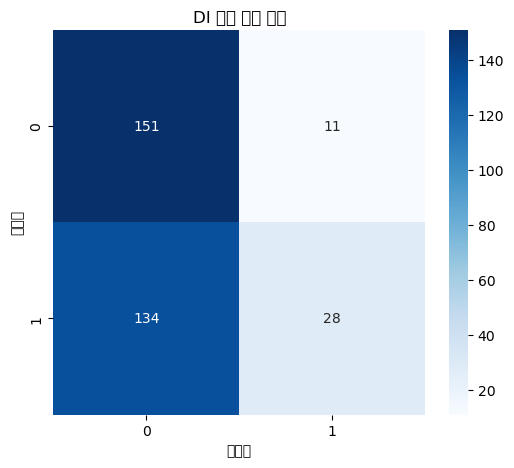

PermissionError: [Errno 13] Permission denied: 'C:/Hackerton/sample_submission5.csv'

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# 데이터 로드
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# 숫자형 데이터만 선택하여 결측치 처리
numeric_features = test_df.select_dtypes(include=[np.number]).columns

imputer = SimpleImputer(strategy="mean")
train_df[numeric_features] = imputer.fit_transform(train_df[numeric_features])
test_df[numeric_features] = imputer.transform(test_df[numeric_features])

# '배아 이식 성공률' Feature 생성
train_df["배아 이식 성공률"] = np.where(
    train_df["총 생성 배아 수"] > 0,
    train_df["이식된 배아 수"] / train_df["총 생성 배아 수"],
    0
)

test_df["배아 이식 성공률"] = np.where(
    test_df["총 생성 배아 수"] > 0,
    test_df["이식된 배아 수"] / test_df["총 생성 배아 수"],
    0
)

# 종속변수 및 시술 유형 컬럼
TARGET = "임신 성공 여부"
PROCEDURE_TYPE = "시술 유형"

# IVF와 DI 데이터 분리
train_ivf = train_df[train_df[PROCEDURE_TYPE] == 1].copy()
train_di = train_df[train_df[PROCEDURE_TYPE] == 0].copy()
test_ivf = test_df[test_df[PROCEDURE_TYPE] == 1].copy()
test_di = test_df[test_df[PROCEDURE_TYPE] == 0].copy()

# 사용 변수 정의
ivf_features = [
    "시술 당시 나이", "배란 유도 유형", "총 생성 배아 수", "이식된 배아 수", "배아 이식 성공률",
    "난자 채취 경과일", "배아 이식 경과일", "배아 해동 경과일", "총 시술 횟수", "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "총 출산 횟수", "IVF 출산 횟수",
    "남성 주 불임 원인", "여성 주 불임 원인", "불명확 불임 원인", "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인", "불임 원인 - 배란 장애", "불임 원인 - 자궁내막증",
    "특정 시술 - ICSI", "특정 시술 - IVF", "특정 시술 - FER"
]

di_features = [
    "시술 당시 나이", "총 시술 횟수", "배란 유도 유형", "DI 시술 횟수", "임신 시도 또는 마지막 임신 경과 연수",
    "난자 출처", "정자 출처", "난자 기증자 나이", "정자 기증자 나이", "총 출산 횟수", "DI 출산 횟수",
    "남성 주 불임 원인", "여성 주 불임 원인", "불명확 불임 원인", "불임 원인 - 배란 장애",
    "특정 시술 - Generic DI", "특정 시술 - IUI"
]

X_ivf, y_ivf = train_ivf[ivf_features], train_ivf[TARGET]
X_di, y_di = train_di[di_features], train_di[TARGET]

# 데이터 분할
X_ivf_train, X_ivf_test, y_ivf_train, y_ivf_test = train_test_split(
    X_ivf, y_ivf, test_size=0.2, stratify=y_ivf, random_state=42
)
X_di_train, X_di_test, y_di_train, y_di_test = train_test_split(
    X_di, y_di, test_size=0.2, stratify=y_di, random_state=42
)

# 테스트 데이터 0과 1이 1:1이 되도록 언더샘플링
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

X_ivf_test, y_ivf_test = rus.fit_resample(X_ivf_test, y_ivf_test)
X_di_test, y_di_test = rus.fit_resample(X_di_test, y_di_test)

# 학습 데이터는 SMOTE 적용
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_ivf_train_resampled, y_ivf_train_resampled = smote.fit_resample(X_ivf_train, y_ivf_train)
X_di_train_resampled, y_di_train_resampled = smote.fit_resample(X_di_train, y_di_train)

# IVF 모델 학습 및 평가
model_ivf = xgb.XGBClassifier(eval_metric="logloss")
model_ivf.fit(X_ivf_train_resampled, y_ivf_train_resampled)
y_ivf_pred = model_ivf.predict(X_ivf_test)

print("✅ IVF 모델 평가")
print(f"정확도: {accuracy_score(y_ivf_test, y_ivf_pred):.4f}")
print("분류 보고서:\n", classification_report(y_ivf_test, y_ivf_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_ivf_test, y_ivf_pred), annot=True, fmt="d", cmap="Blues")
plt.title("IVF 모델 혼동 행렬")
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.show()

# DI 모델 학습 및 평가
model_di = xgb.XGBClassifier(eval_metric="logloss")
model_di.fit(X_di_train_resampled, y_di_train_resampled)
y_di_pred = model_di.predict(X_di_test)

print("✅ DI 모델 평가")
print(f"정확도: {accuracy_score(y_di_test, y_di_pred):.4f}")
print("분류 보고서:\n", classification_report(y_di_test, y_di_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_di_test, y_di_pred), annot=True, fmt="d", cmap="Blues")
plt.title("DI 모델 혼동 행렬")
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.show()

# 최종 예측 및 저장
test_ivf["probability"] = model_ivf.predict(test_ivf[ivf_features])
test_di["probability"] = model_di.predict(test_di[di_features])

submission = pd.concat([test_ivf[["ID", "probability"]], test_di[["ID", "probability"]]])
submission.to_csv(submission_file_path, index=False)

print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")



✅ XGBoost IVF 모델 학습 중...
✅ XGBoost IVF 모델 정확도: 0.6184


C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

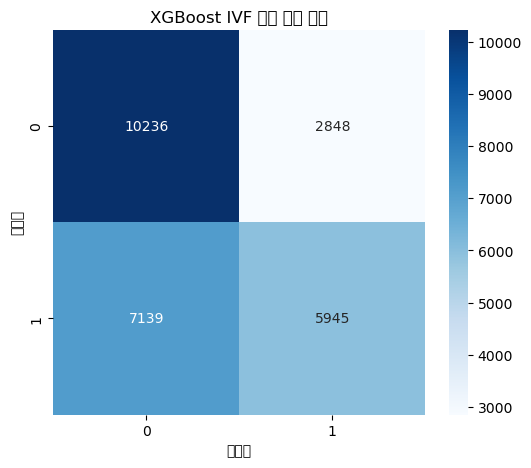


✅ RandomForest IVF 모델 학습 중...
✅ RandomForest IVF 모델 정확도: 0.5803


C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

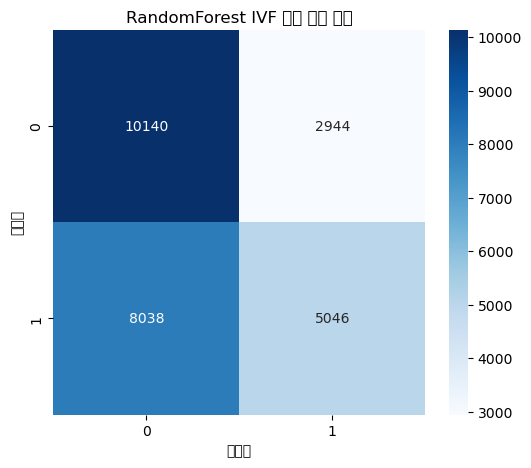

🔥 IVF 모델 최종 선택: XGBClassifier (정확도: 0.6184)

✅ XGBoost DI 모델 학습 중...
✅ XGBoost DI 모델 정확도: 0.5617


C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

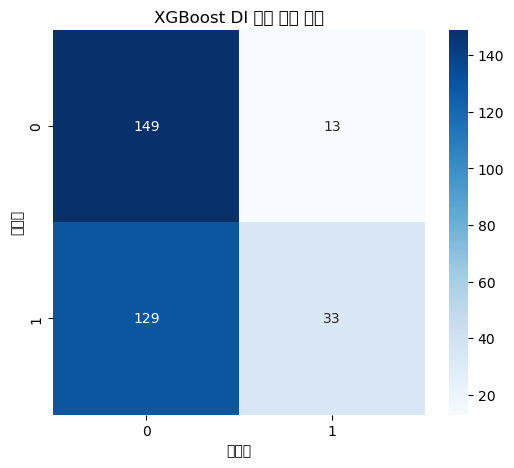


✅ RandomForest DI 모델 학습 중...
✅ RandomForest DI 모델 정확도: 0.5617


C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pung\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

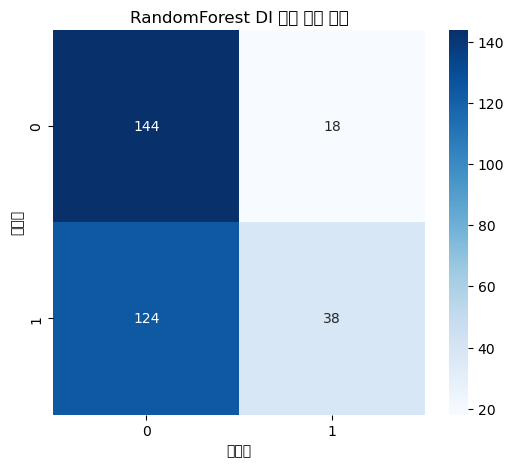

🔥 DI 모델 최종 선택: XGBClassifier (정확도: 0.5617)


ValueError: feature_names mismatch: ['시술 당시 나이', '총 시술 횟수', '배란 유도 유형', 'DI 시술 횟수', '임신 시도 또는 마지막 임신 경과 연수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이', '총 출산 횟수', 'DI 출산 횟수', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '특정 시술 - Generic DI', '특정 시술 - IUI'] ['시술 당시 나이', '배란 유도 유형', '총 생성 배아 수', '이식된 배아 수', '배아 이식 성공률', '난자 채취 경과일', '배아 이식 경과일', '배아 해동 경과일', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', '저장된 배아 수', '수집된 신선 난자 수', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '특정 시술 - ICSI', '특정 시술 - IVF', '특정 시술 - FER']
expected DI 시술 횟수, 특정 시술 - Generic DI, 임신 시도 또는 마지막 임신 경과 연수, DI 출산 횟수, 난자 출처, 정자 기증자 나이, 특정 시술 - IUI, 난자 기증자 나이, 정자 출처 in input data
training data did not have the following fields: IVF 임신 횟수, 난자 채취 경과일, 총 생성 배아 수, 저장된 배아 수, 배아 해동 경과일, 배아 이식 경과일, 이식된 배아 수, IVF 시술 횟수, 수집된 신선 난자 수, 클리닉 내 총 시술 횟수, 특정 시술 - ICSI, IVF 출산 횟수, 총 임신 횟수, 배아 이식 성공률, 특정 시술 - IVF, 특정 시술 - FER

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# 데이터 로드
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# 숫자형 데이터만 선택하여 결측치 처리
numeric_features = test_df.select_dtypes(include=[np.number]).columns

imputer = SimpleImputer(strategy="mean")
train_df[numeric_features] = imputer.fit_transform(train_df[numeric_features])
test_df[numeric_features] = imputer.transform(test_df[numeric_features])

# '배아 이식 성공률' Feature 생성
train_df["배아 이식 성공률"] = np.where(
    train_df["총 생성 배아 수"] > 0,
    train_df["이식된 배아 수"] / train_df["총 생성 배아 수"],
    0
)

test_df["배아 이식 성공률"] = np.where(
    test_df["총 생성 배아 수"] > 0,
    test_df["이식된 배아 수"] / test_df["총 생성 배아 수"],
    0
)

# 종속변수 및 시술 유형 컬럼
TARGET = "임신 성공 여부"
PROCEDURE_TYPE = "시술 유형"

# IVF와 DI 데이터 분리
train_ivf = train_df[train_df[PROCEDURE_TYPE] == 1].copy()
train_di = train_df[train_df[PROCEDURE_TYPE] == 0].copy()
test_ivf = test_df[test_df[PROCEDURE_TYPE] == 1].copy()
test_di = test_df[test_df[PROCEDURE_TYPE] == 0].copy()

# 사용 변수 정의
ivf_features = [
    "시술 당시 나이", "배란 유도 유형", "총 생성 배아 수", "이식된 배아 수", "배아 이식 성공률",
    "난자 채취 경과일", "배아 이식 경과일", "배아 해동 경과일", "총 시술 횟수", "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "총 출산 횟수", "IVF 출산 횟수",
    "저장된 배아 수", "수집된 신선 난자 수", "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부",
    "특정 시술 - ICSI", "특정 시술 - IVF", "특정 시술 - FER"
]

di_features = [
    "시술 당시 나이", "총 시술 횟수", "배란 유도 유형", "DI 시술 횟수", "임신 시도 또는 마지막 임신 경과 연수",
    "난자 출처", "정자 출처", "난자 기증자 나이", "정자 기증자 나이", "총 출산 횟수", "DI 출산 횟수",
    "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부",
    "특정 시술 - Generic DI", "특정 시술 - IUI"
]

X_ivf, y_ivf = train_ivf[ivf_features], train_ivf[TARGET]
X_di, y_di = train_di[di_features], train_di[TARGET]

# 데이터 분할
X_ivf_train, X_ivf_test, y_ivf_train, y_ivf_test = train_test_split(
    X_ivf, y_ivf, test_size=0.2, stratify=y_ivf, random_state=42
)
X_di_train, X_di_test, y_di_train, y_di_test = train_test_split(
    X_di, y_di, test_size=0.2, stratify=y_di, random_state=42
)

# 테스트 데이터 0과 1이 1:1이 되도록 언더샘플링
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_ivf_test, y_ivf_test = rus.fit_resample(X_ivf_test, y_ivf_test)
X_di_test, y_di_test = rus.fit_resample(X_di_test, y_di_test)

# 학습 데이터는 SMOTE 적용
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_ivf_train_resampled, y_ivf_train_resampled = smote.fit_resample(X_ivf_train, y_ivf_train)
X_di_train_resampled, y_di_train_resampled = smote.fit_resample(X_di_train, y_di_train)

# IVF & DI 모델 학습 및 평가 (XGBoost + RandomForest)
models = {
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss"),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

best_models = {}

for procedure, (X_train, X_test, y_train, y_test, features, test_data) in {
    "IVF": (X_ivf_train_resampled, X_ivf_test, y_ivf_train_resampled, y_ivf_test, ivf_features, test_ivf),
    "DI": (X_di_train_resampled, X_di_test, y_di_train_resampled, y_di_test, di_features, test_di)
}.items():
    
    best_model = None
    best_accuracy = 0

    for name, model in models.items():
        print(f"\n✅ {name} {procedure} 모델 학습 중...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print(f"✅ {name} {procedure} 모델 정확도: {accuracy:.4f}")

        plt.figure(figsize=(6, 5))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} {procedure} 모델 혼동 행렬")
        plt.xlabel("예측값")
        plt.ylabel("실제값")
        plt.show()

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    best_models[procedure] = best_model
    print(f"🔥 {procedure} 모델 최종 선택: {best_model.__class__.__name__} (정확도: {best_accuracy:.4f})")

# 최종 예측 및 저장
test_ivf["probability"] = best_models["IVF"].predict(test_ivf[ivf_features])
test_di["probability"] = best_models["DI"].predict(test_di[di_features])

submission = pd.concat([test_ivf[["ID", "probability"]], test_di[["ID", "probability"]]])
submission.to_csv(submission_file_path, index=False)

print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import optuna

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# 데이터 로드
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# 숫자형 데이터만 선택하여 결측치 처리
numeric_features = test_df.select_dtypes(include=[np.number]).columns

imputer = SimpleImputer(strategy="mean")
train_df[numeric_features] = imputer.fit_transform(train_df[numeric_features])
test_df[numeric_features] = imputer.transform(test_df[numeric_features])

# 새로운 Feature 생성 ('배아 이식 성공률')
train_df["배아 이식 성공률"] = np.where(
    train_df["총 생성 배아 수"] > 0,
    train_df["이식된 배아 수"] / train_df["총 생성 배아 수"],
    0  # 분모가 0이면 0으로 처리
)

test_df["배아 이식 성공률"] = np.where(
    test_df["총 생성 배아 수"] > 0,
    test_df["이식된 배아 수"] / test_df["총 생성 배아 수"],
    0  # 분모가 0이면 0으로 처리
)

# 종속변수 및 시술 유형 컬럼
TARGET = "임신 성공 여부"
PROCEDURE_TYPE = "시술 유형"

# IVF와 DI 데이터 분리
train_ivf = train_df[train_df[PROCEDURE_TYPE] == 1].copy()
train_di = train_df[train_df[PROCEDURE_TYPE] == 0].copy()
test_ivf = test_df[test_df[PROCEDURE_TYPE] == 1].copy()
test_di = test_df[test_df[PROCEDURE_TYPE] == 0].copy()

# 사용 변수 정의 (IVF & DI Feature 선정)
ivf_features = [
    "시술 당시 나이", "배란 유도 유형", "총 생성 배아 수", "이식된 배아 수", "배아 이식 성공률",
    "난자 채취 경과일", "배아 이식 경과일", "배아 해동 경과일", "총 시술 횟수", "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "총 출산 횟수", "IVF 출산 횟수",
    "남성 주 불임 원인", "여성 주 불임 원인", "불명확 불임 원인", "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인", "불임 원인 - 배란 장애", "불임 원인 - 자궁내막증",
    "특정 시술 - ICSI", "특정 시술 - IVF", "특정 시술 - FER"
]

di_features = [
    "시술 당시 나이", "총 시술 횟수", "배란 유도 유형", "DI 시술 횟수", "임신 시도 또는 마지막 임신 경과 연수",
    "난자 출처", "정자 출처", "난자 기증자 나이", "정자 기증자 나이", "총 출산 횟수", "DI 출산 횟수",
    "남성 주 불임 원인", "여성 주 불임 원인", "불명확 불임 원인", "불임 원인 - 배란 장애",
    "특정 시술 - Generic DI", "특정 시술 - IUI"
]

X_ivf, y_ivf = train_ivf[ivf_features], train_ivf[TARGET]
X_di, y_di = train_di[di_features], train_di[TARGET]

# 1:1 비율로 테스트 데이터 분할
X_ivf_train, X_ivf_test, y_ivf_train, y_ivf_test = train_test_split(
    X_ivf, y_ivf, test_size=0.2, stratify=y_ivf, random_state=42
)
X_di_train, X_di_test, y_di_train, y_di_test = train_test_split(
    X_di, y_di, test_size=0.2, stratify=y_di, random_state=42
)

# SMOTE 적용 (학습 데이터 증강)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_ivf_train_resampled, y_ivf_train_resampled = smote.fit_resample(X_ivf_train, y_ivf_train)
X_di_train_resampled, y_di_train_resampled = smote.fit_resample(X_di_train, y_di_train)

# IVF & DI 모델 학습을 위한 VotingClassifier 구성
ivf_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(eval_metric="logloss"))
]

di_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(eval_metric="logloss"))
]

voting_ivf = VotingClassifier(estimators=ivf_estimators, voting='hard')  # hard voting 사용
voting_ivf.fit(X_ivf_train_resampled, y_ivf_train_resampled)

voting_di = VotingClassifier(estimators=di_estimators, voting='hard')
voting_di.fit(X_di_train_resampled, y_di_train_resampled)

# IVF & DI 예측 (predict() 사용)
test_ivf["probability"] = voting_ivf.predict(test_ivf[ivf_features])
test_di["probability"] = voting_di.predict(test_di[di_features])

# 최종 제출 파일 저장
submission = pd.concat([test_ivf[["ID", "probability"]], test_di[["ID", "probability"]]])
submission.to_csv(submission_file_path, index=False)
print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")


C:\Users\pung\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\pung\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


✅ 최종 제출 파일 저장 완료: C:/Hackerton/sample_submission5.csv



🔹 IVF 모델 평가 결과
✅ 정확도 (Accuracy): 0.6732784131808366
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.82      0.71      0.76     36928
         1.0       0.41      0.56      0.47     13084

    accuracy                           0.67     50012
   macro avg       0.61      0.64      0.62     50012
weighted avg       0.71      0.67      0.69     50012



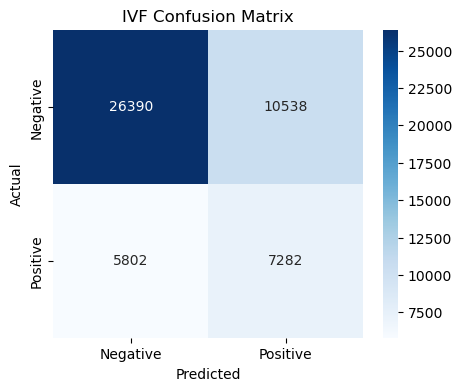


🔹 DI 모델 평가 결과
✅ 정확도 (Accuracy): 0.8236695790309769
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      1097
         1.0       0.26      0.20      0.22       162

    accuracy                           0.82      1259
   macro avg       0.57      0.56      0.56      1259
weighted avg       0.80      0.82      0.81      1259



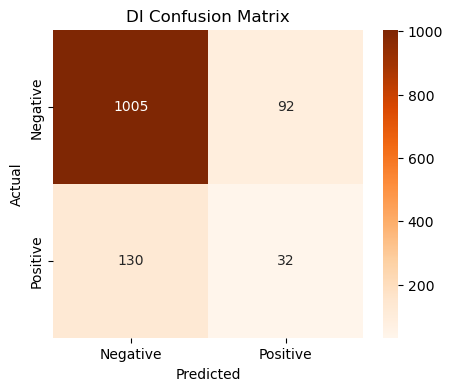

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# IVF & DI 테스트 데이터 예측
y_ivf_pred = voting_ivf.predict(X_ivf_test)
y_di_pred = voting_di.predict(X_di_test)

# IVF 평가
print("\n🔹 IVF 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_ivf_test, y_ivf_pred))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_ivf_test, y_ivf_pred))

# 컨퓨전 매트릭스 시각화 (IVF)
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_ivf_test, y_ivf_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("IVF Confusion Matrix")
plt.show()

# DI 평가
print("\n🔹 DI 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_di_test, y_di_pred))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_di_test, y_di_pred))

# 컨퓨전 매트릭스 시각화 (DI)
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_di_test, y_di_pred), annot=True, fmt='d', cmap='Oranges', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DI Confusion Matrix")
plt.show()


🔹 언더샘플링 후 레이블 분포
임신 성공 여부
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

🚀 Hard Voting 모델 학습 시작...


C:\Users\pung\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ Hard Voting 모델 학습 완료!


🔹 Hard Voting 모델 평가 결과
✅ 정확도 (Accuracy): 0.6734347571679344
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.72      0.57      0.64     25635
         1.0       0.64      0.77      0.70     25635

    accuracy                           0.67     51270
   macro avg       0.68      0.67      0.67     51270
weighted avg       0.68      0.67      0.67     51270


🚀 Soft Voting 모델 학습 시작...


C:\Users\pung\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ Soft Voting 모델 학습 완료!


🔹 Soft Voting 모델 평가 결과
✅ 정확도 (Accuracy): 0.6653403549834211
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.70      0.57      0.63     25635
         1.0       0.64      0.76      0.69     25635

    accuracy                           0.67     51270
   macro avg       0.67      0.67      0.66     51270
weighted avg       0.67      0.67      0.66     51270



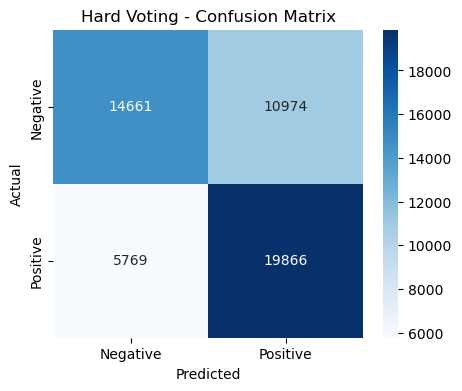

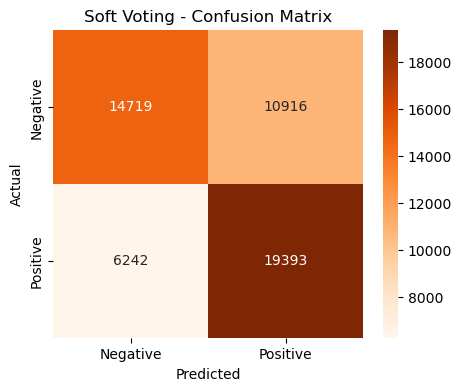


🚀 최종 테스트 데이터 예측 중...
✅ 최종 예측 완료!

✅ 최종 제출 파일 저장 완료: C:/Hackerton/sample_submission5.csv


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler  # 언더샘플링 적용
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission5.csv"

# 데이터 로드
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# 숫자형 데이터만 선택 (타겟 변수 '임신 성공 여부' 제외)
numeric_features = train_df.select_dtypes(include=[np.number]).columns.drop("임신 성공 여부", errors="ignore")

# 결측치 처리 (평균값으로 대체)
imputer = SimpleImputer(strategy="mean")
train_df[numeric_features] = imputer.fit_transform(train_df[numeric_features])
test_df[numeric_features] = imputer.transform(test_df[numeric_features])  

# 새로운 Feature 생성 ('배아 이식 성공률')
train_df["배아 이식 성공률"] = np.where(
    train_df["총 생성 배아 수"] > 0,
    train_df["이식된 배아 수"] / train_df["총 생성 배아 수"],
    0  
)

test_df["배아 이식 성공률"] = np.where(
    test_df["총 생성 배아 수"] > 0,
    test_df["이식된 배아 수"] / test_df["총 생성 배아 수"],
    0  
)

# 종속변수 및 독립변수 설정
TARGET = "임신 성공 여부"
FEATURES = [col for col in train_df.columns if col != TARGET and col != "ID"]

X, y = train_df[FEATURES], train_df[TARGET]
X_test_final = test_df[FEATURES]  

# 🎯 1:1 비율로 Test 데이터 분할 (20% 중 절반이 1, 절반이 0)
test_size = int(len(y) * 0.2 / 2)  

y_0 = y[y == 0]
y_1 = y[y == 1]

# 1과 0에서 동일한 개수 추출 (각각 test_size만큼)
y_test_0 = y_0.sample(n=test_size, random_state=42)
y_test_1 = y_1.sample(n=test_size, random_state=42)

# 나머지 데이터는 train으로 사용
y_train_0 = y_0.drop(y_test_0.index)
y_train_1 = y_1.drop(y_test_1.index)

# X도 동일하게 맞춰줌
X_test = pd.concat([X.loc[y_test_0.index], X.loc[y_test_1.index]])
y_test = pd.concat([y_test_0, y_test_1])

X_train = pd.concat([X.loc[y_train_0.index], X.loc[y_train_1.index]])
y_train = pd.concat([y_train_0, y_train_1])

# 🎯 언더샘플링 적용 (0과 1을 동일 개수로 맞춤)
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # 0과 1을 50:50으로 유지
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("\n🔹 언더샘플링 후 레이블 분포")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# 🎯 트리 기반 모델 + 에이다부스트 포함
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(eval_metric="logloss")

# VotingClassifier (Hard Voting)
voting_clf_hard = VotingClassifier(
    estimators=[('rf', rf_clf), ('ada', ada_clf), ('xgb', xgb_clf)], voting='hard'
)

# VotingClassifier (Soft Voting)
voting_clf_soft = VotingClassifier(
    estimators=[('rf', rf_clf), ('ada', ada_clf), ('xgb', xgb_clf)], voting='soft'
)

# 🏋️‍♂️ 모델 학습 수행 (Hard Voting)
print("\n🚀 Hard Voting 모델 학습 시작...")
voting_clf_hard.fit(X_train_resampled, y_train_resampled)
print("✅ Hard Voting 모델 학습 완료!\n")

# 📊 모델 평가 (Hard Voting)
y_pred_hard = voting_clf_hard.predict(X_test)

print("\n🔹 Hard Voting 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred_hard))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_hard))

# 🏋️‍♂️ 모델 학습 수행 (Soft Voting)
print("\n🚀 Soft Voting 모델 학습 시작...")
voting_clf_soft.fit(X_train_resampled, y_train_resampled)
print("✅ Soft Voting 모델 학습 완료!\n")

# 📊 모델 평가 (Soft Voting)
y_pred_soft = voting_clf_soft.predict(X_test)

print("\n🔹 Soft Voting 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred_soft))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_soft))

# 🖼️ 컨퓨전 매트릭스 시각화 (Hard Voting)
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_hard), annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Hard Voting - Confusion Matrix")
plt.show()

# 🖼️ 컨퓨전 매트릭스 시각화 (Soft Voting)
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_soft), annot=True, fmt='d', cmap='Oranges', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Soft Voting - Confusion Matrix")
plt.show()

# 🎯 Soft Voting을 기반으로 최종 test 데이터 예측
print("\n🚀 최종 테스트 데이터 예측 중...")
test_df["probability"] = voting_clf_soft.predict(X_test_final)
print("✅ 최종 예측 완료!\n")

# 📂 제출 파일 저장
submission = test_df[["ID", "probability"]]
submission.to_csv(submission_file_path, index=False)
print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")


In [13]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# CSV 파일 경로
train_file_path = "C:/Hackerton/train_fifi.csv"
test_file_path = "C:/Hackerton/test_fifi.csv"
submission_file_path = "C:/Hackerton/sample_submission6.csv"

# 데이터 로드
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# 숫자형 데이터만 선택 (타겟 변수 '임신 성공 여부' 제외)
numeric_features = train_df.select_dtypes(include=[np.number]).columns.drop("임신 성공 여부", errors="ignore")

# 결측치 처리 (평균값으로 대체)
imputer = SimpleImputer(strategy="mean")
train_df[numeric_features] = imputer.fit_transform(train_df[numeric_features])
test_df[numeric_features] = imputer.transform(test_df[numeric_features])  

# 새로운 Feature 생성 ('배아 이식 성공률')
train_df["배아 이식 성공률"] = np.where(
    train_df["총 생성 배아 수"] > 0,
    train_df["이식된 배아 수"] / train_df["총 생성 배아 수"],
    0  
)

test_df["배아 이식 성공률"] = np.where(
    test_df["총 생성 배아 수"] > 0,
    test_df["이식된 배아 수"] / test_df["총 생성 배아 수"],
    0  
)

# 종속변수 및 독립변수 설정
TARGET = "임신 성공 여부"
FEATURES = [col for col in train_df.columns if col != TARGET and col != "ID"]

X, y = train_df[FEATURES], train_df[TARGET]
X_test_final = test_df[FEATURES]  

# 🎯 1:1 비율로 Test 데이터 분할 (20% 중 절반이 1, 절반이 0)
test_size = int(len(y) * 0.2 / 2)  

y_0 = y[y == 0]
y_1 = y[y == 1]

# 1과 0에서 동일한 개수 추출 (각각 test_size만큼)
y_test_0 = y_0.sample(n=test_size, random_state=42)
y_test_1 = y_1.sample(n=test_size, random_state=42)

# 나머지 데이터는 train으로 사용
y_train_0 = y_0.drop(y_test_0.index)
y_train_1 = y_1.drop(y_test_1.index)

# X도 동일하게 맞춰줌
X_test = pd.concat([X.loc[y_test_0.index], X.loc[y_test_1.index]])
y_test = pd.concat([y_test_0, y_test_1])

X_train = pd.concat([X.loc[y_train_0.index], X.loc[y_train_1.index]])
y_train = pd.concat([y_train_0, y_train_1])

# 🎯 언더샘플링 적용 (0과 1을 동일 개수로 맞춤)
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("\n🔹 언더샘플링 후 레이블 분포")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# 🎯 Optuna를 사용한 하이퍼파라미터 튜닝
def objective(trial):
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 300, step=50)
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 20)

    ada_n_estimators = trial.suggest_int("ada_n_estimators", 50, 300, step=50)
    ada_learning_rate = trial.suggest_float("ada_learning_rate", 0.01, 1.0, log=True)

    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 50, 300, step=50)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 15)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True)

    rf = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth, random_state=42)
    ada = AdaBoostClassifier(n_estimators=ada_n_estimators, learning_rate=ada_learning_rate, random_state=42)
    xgb_model = xgb.XGBClassifier(n_estimators=xgb_n_estimators, max_depth=xgb_max_depth, learning_rate=xgb_learning_rate, eval_metric="logloss")

    voting_clf = VotingClassifier(estimators=[('rf', rf), ('ada', ada), ('xgb', xgb_model)], voting='soft')
    voting_clf.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, voting_clf.predict(X_test))

# 🎯 최적의 하이퍼파라미터 찾기
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("\n✅ 최적의 하이퍼파라미터:")
print(best_params)

# 🎯 최적의 파라미터 적용
rf_clf = RandomForestClassifier(n_estimators=best_params["rf_n_estimators"], max_depth=best_params["rf_max_depth"], random_state=42)
ada_clf = AdaBoostClassifier(n_estimators=best_params["ada_n_estimators"], learning_rate=best_params["ada_learning_rate"], random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=best_params["xgb_n_estimators"], max_depth=best_params["xgb_max_depth"], learning_rate=best_params["xgb_learning_rate"], eval_metric="logloss")

# 🎯 CatBoost 모델 추가
cat_clf = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, verbose=0, random_state=42)

# 최적의 모델을 사용한 Soft Voting
voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('ada', ada_clf), ('xgb', xgb_clf)], voting='soft')

# 🏋️‍♂️ 모델 학습 수행
print("\n🚀 최적화된 모델 학습 시작...")
voting_clf.fit(X_train_resampled, y_train_resampled)
print("✅ 모델 학습 완료!\n")

# 📊 모델 평가
y_pred = voting_clf.predict(X_test)

print("\n🔹 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred))

# 🎯 학습된 모델로 최종 test 데이터 예측
print("\n🚀 최종 테스트 데이터 예측 중...")
test_df["probability"] = voting_clf.predict(X_test_final)
print("✅ 최종 예측 완료!\n")

# 📂 제출 파일 저장
submission = test_df[["ID", "probability"]]
submission.to_csv(submission_file_path, index=False)
print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")


[I 2025-02-17 18:29:20,158] A new study created in memory with name: no-name-aab7dcc4-20a9-466a-8b24-7d38b0009b01



🔹 언더샘플링 후 레이블 분포
임신 성공 여부
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


C:\Users\pung\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-02-17 18:29:31,567] Trial 0 finished with value: 0.6705285742149405 and parameters: {'rf_n_estimators': 100, 'rf_max_depth': 7, 'ada_n_estimators': 50, 'ada_learning_rate': 0.25951149757459735, 'xgb_n_estimators': 150, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.016823634046214946}. Best is trial 0 with value: 0.6705285742149405.
C:\Users\pung\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-02-17 18:29:59,085] Trial 1 finished with value: 0.6713087575580261 and parameters: {'rf_n_estimators': 250, 'rf_max_depth': 7, 'ada_n_estimators': 150, 'ada_lea


✅ 최적의 하이퍼파라미터:
{'rf_n_estimators': 250, 'rf_max_depth': 13, 'ada_n_estimators': 300, 'ada_learning_rate': 0.03504447489392597, 'xgb_n_estimators': 300, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.1479251513181497}

🚀 최적화된 모델 학습 시작...


C:\Users\pung\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ 모델 학습 완료!


🔹 모델 평가 결과
✅ 정확도 (Accuracy): 0.6745465184318314
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.72      0.56      0.63     25635
         1.0       0.64      0.79      0.71     25635

    accuracy                           0.67     51270
   macro avg       0.68      0.67      0.67     51270
weighted avg       0.68      0.67      0.67     51270


🚀 최종 테스트 데이터 예측 중...
✅ 최종 예측 완료!

✅ 최종 제출 파일 저장 완료: C:/Hackerton/sample_submission6.csv


In [31]:
# 🎯 가중치 조정 (랜덤 포레스트 영향력 증가)
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('ada', ada_clf), ('xgb', xgb_clf), ('cat', cat_clf)], 
    voting='soft',
    weights=[1,0,0,1]  # 랜덤 포레스트(4), 에이다부스트(1), XGBoost(2), CatBoost(3)
)

# 🏋️‍♂️ 모델 학습 수행
print("\n🚀 모델 학습 시작 (랜덤 포레스트 가중치 ↑ & CatBoost 추가)...")
voting_clf.fit(X_train_resampled, y_train_resampled)
print("✅ 모델 학습 완료!\n")

# 📊 모델 평가
y_pred = voting_clf.predict(X_test)

print("\n🔹 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred))


🚀 모델 학습 시작 (랜덤 포레스트 가중치 ↑ & CatBoost 추가)...


C:\Users\pung\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ 모델 학습 완료!


🔹 모델 평가 결과
✅ 정확도 (Accuracy): 0.6742734542617516
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.72      0.56      0.63     25635
         1.0       0.64      0.79      0.71     25635

    accuracy                           0.67     51270
   macro avg       0.68      0.67      0.67     51270
weighted avg       0.68      0.67      0.67     51270



In [22]:
# 🎯 CatBoost 최적화 함수
def objective(trial):
    cat_iterations = trial.suggest_int("cat_iterations", 100, 500, step=100)
    cat_depth = trial.suggest_int("cat_depth", 4, 10)
    cat_learning_rate = trial.suggest_float("cat_learning_rate", 0.01, 0.3, log=True)

    cat = CatBoostClassifier(iterations=cat_iterations, depth=cat_depth, learning_rate=cat_learning_rate, verbose=0, random_state=42)

    # Voting Classifier 없이 CatBoost 단독 평가
    cat.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, cat.predict(X_test))

# 🎯 Optuna 최적화 실행 (n_trials=20번 반복)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# 🎯 최적의 CatBoost 하이퍼파라미터 찾기
best_params = study.best_params
print("\n✅ 최적의 CatBoost 하이퍼파라미터:")
print(best_params)

# 🎯 최적화된 CatBoost 모델 정의
cat_clf = CatBoostClassifier(
    iterations=best_params["cat_iterations"], 
    depth=best_params["cat_depth"], 
    learning_rate=best_params["cat_learning_rate"], 
    verbose=0, 
    random_state=42
)

# 🎯 기존 모델 (고정된 하이퍼파라미터 사용)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
ada_clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, eval_metric="logloss", random_state=42)

# 🎯 최적화된 CatBoost 포함 Soft Voting 앙상블
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('ada', ada_clf), ('xgb', xgb_clf), ('cat', cat_clf)], 
    voting='soft',
    weights=[4, 1, 2, 3]  # 랜덤 포레스트(4), 에이다부스트(1), XGBoost(2), CatBoost(3)
)

# 🏋️‍♂️ 최적화된 모델 학습 수행
print("\n🚀 최적화된 CatBoost 포함 모델 학습 시작...")
voting_clf.fit(X_train_resampled, y_train_resampled)
print("✅ 모델 학습 완료!\n")

# 📊 모델 평가
y_pred = voting_clf.predict(X_test)

print("\n🔹 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred))

# 🎯 학습된 모델로 최종 test 데이터 예측
print("\n🚀 최종 테스트 데이터 예측 중...")
test_df["probability"] = voting_clf.predict(X_test_final)
print("✅ 최종 예측 완료!\n")

# 📂 제출 파일 저장
submission = test_df[["ID", "probability"]]
submission.to_csv(submission_file_path, index=False)
print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")


[I 2025-02-17 19:02:49,720] A new study created in memory with name: no-name-c3d0b920-ff88-4dca-b129-81a060492ea9
[I 2025-02-17 19:02:53,521] Trial 0 finished with value: 0.6701579871269748 and parameters: {'cat_iterations': 200, 'cat_depth': 5, 'cat_learning_rate': 0.011996604958842583}. Best is trial 0 with value: 0.6701579871269748.
[I 2025-02-17 19:03:06,362] Trial 1 finished with value: 0.6751121513555686 and parameters: {'cat_iterations': 400, 'cat_depth': 9, 'cat_learning_rate': 0.01468871384863016}. Best is trial 1 with value: 0.6751121513555686.
[I 2025-02-17 19:03:08,277] Trial 2 finished with value: 0.6730056563292374 and parameters: {'cat_iterations': 100, 'cat_depth': 5, 'cat_learning_rate': 0.050373279625284616}. Best is trial 1 with value: 0.6751121513555686.
[I 2025-02-17 19:03:12,090] Trial 3 finished with value: 0.6718743904817632 and parameters: {'cat_iterations': 200, 'cat_depth': 5, 'cat_learning_rate': 0.016717442163296344}. Best is trial 1 with value: 0.675112151


✅ 최적의 CatBoost 하이퍼파라미터:
{'cat_iterations': 400, 'cat_depth': 7, 'cat_learning_rate': 0.03222964329853466}

🚀 최적화된 CatBoost 포함 모델 학습 시작...


C:\Users\pung\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ 모델 학습 완료!


🔹 모델 평가 결과
✅ 정확도 (Accuracy): 0.6740003900916716
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.72      0.56      0.63     25635
         1.0       0.64      0.78      0.71     25635

    accuracy                           0.67     51270
   macro avg       0.68      0.67      0.67     51270
weighted avg       0.68      0.67      0.67     51270


🚀 최종 테스트 데이터 예측 중...
✅ 최종 예측 완료!

✅ 최종 제출 파일 저장 완료: C:/Hackerton/sample_submission6.csv


In [33]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# ✅ Random Forest: 이전에 찾은 최적의 하이퍼파라미터 적용
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)

# ✅ Optuna를 사용하여 나머지 4개 모델 최적화
def objective(trial):
    # Logistic Regression 하이퍼파라미터
    log_reg_c = trial.suggest_float("log_reg_c", 0.01, 10.0, log=True)
    
    # Decision Tree 하이퍼파라미터
    dt_max_depth = trial.suggest_int("dt_max_depth", 3, 20)
    
    # LDA 하이퍼파라미터 (solver='eigen' 제외)
    lda_solver = trial.suggest_categorical("lda_solver", ["svd", "lsqr"])

    # KNN 하이퍼파라미터
    knn_n_neighbors = trial.suggest_int("knn_n_neighbors", 3, 15)
    knn_weights = trial.suggest_categorical("knn_weights", ["uniform", "distance"])

    # 모델 정의
    log_reg = LogisticRegression(C=log_reg_c, max_iter=1000, random_state=42)
    dt = DecisionTreeClassifier(max_depth=dt_max_depth, random_state=42)
    lda = LinearDiscriminantAnalysis(solver=lda_solver, shrinkage="auto" if lda_solver == "lsqr" else None)  # shrinkage 추가
    knn = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights)

    # 소프트 보팅 앙상블
    voting_clf = VotingClassifier(
        estimators=[('lr', log_reg), ('dt', dt), ('lda', lda), ('rf', rf_clf), ('knn', knn)], 
        voting='soft'
    )

    # 모델 학습
    voting_clf.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, voting_clf.predict(X_test))

# 🎯 Optuna 최적화 실행 (n_trials=20번 반복)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# 🎯 최적의 하이퍼파라미터 찾기
best_params = study.best_params
print("\n✅ 최적의 하이퍼파라미터:")
print(best_params)

# 🎯 최적화된 모델 정의
log_reg_clf = LogisticRegression(C=best_params["log_reg_c"], max_iter=1000, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=best_params["dt_max_depth"], random_state=42)
lda_clf = LinearDiscriminantAnalysis(solver=best_params["lda_solver"], shrinkage="auto" if best_params["lda_solver"] == "lsqr" else None)
knn_clf = KNeighborsClassifier(n_neighbors=best_params["knn_n_neighbors"], weights=best_params["knn_weights"])

# 🎯 최적화된 모델을 사용한 Soft Voting & Hard Voting
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_reg_clf), ('dt', dt_clf), ('lda', lda_clf), ('rf', rf_clf), ('knn', knn_clf)], 
    voting='soft'
)

voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_reg_clf), ('dt', dt_clf), ('lda', lda_clf), ('rf', rf_clf), ('knn', knn_clf)], 
    voting='hard'
)

# 📊 Soft Voting & Hard Voting 모델 평가
models = {
    "Soft Voting": voting_clf_soft,
    "Hard Voting": voting_clf_hard
}

print("\n🔹 Soft Voting vs Hard Voting 정확도 비교")
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ {name} 정확도 (Accuracy): {acc:.4f}")

# 📊 Soft Voting 모델 분류 리포트
y_pred_soft = voting_clf_soft.predict(X_test)
print("\n🔹 Soft Voting 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred_soft))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_soft))

# 📊 Hard Voting 모델 분류 리포트
y_pred_hard = voting_clf_hard.predict(X_test)
print("\n🔹 Hard Voting 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred_hard))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_hard))

# 🎯 학습된 Soft Voting 모델로 최종 test 데이터 예측
print("\n🚀 Soft Voting 최종 테스트 데이터 예측 중...")
test_df["probability_soft"] = voting_clf_soft.predict(X_test_final)

# 🎯 학습된 Hard Voting 모델로 최종 test 데이터 예측
print("\n🚀 Hard Voting 최종 테스트 데이터 예측 중...")
test_df["probability_hard"] = voting_clf_hard.predict(X_test_final)

# 📂 제출 파일 저장
submission = test_df[["ID", "probability_soft", "probability_hard"]]
submission.to_csv(submission_file_path, index=False)
print(f"✅ 최종 제출 파일 저장 완료: {submission_file_path}")

[I 2025-02-17 19:24:15,098] A new study created in memory with name: no-name-401f6285-68a0-48ff-a349-081afe047d66
[I 2025-02-17 19:24:45,462] Trial 0 finished with value: 0.6616929978544958 and parameters: {'log_reg_c': 0.06031058617359762, 'dt_max_depth': 17, 'lda_solver': 'lsqr', 'knn_n_neighbors': 10, 'knn_weights': 'distance'}. Best is trial 0 with value: 0.6616929978544958.
[I 2025-02-17 19:25:19,238] Trial 1 finished with value: 0.666842207918861 and parameters: {'log_reg_c': 1.6732235804253899, 'dt_max_depth': 6, 'lda_solver': 'svd', 'knn_n_neighbors': 5, 'knn_weights': 'uniform'}. Best is trial 1 with value: 0.666842207918861.
[I 2025-02-17 19:25:52,402] Trial 2 finished with value: 0.6648527403939926 and parameters: {'log_reg_c': 0.36612803770459035, 'dt_max_depth': 10, 'lda_solver': 'svd', 'knn_n_neighbors': 3, 'knn_weights': 'uniform'}. Best is trial 1 with value: 0.666842207918861.
[I 2025-02-17 19:26:27,319] Trial 3 finished with value: 0.667544372927638 and parameters: {'


✅ 최적의 하이퍼파라미터:
{'log_reg_c': 0.14783967349261473, 'dt_max_depth': 6, 'lda_solver': 'lsqr', 'knn_n_neighbors': 12, 'knn_weights': 'distance'}

🔹 Soft Voting vs Hard Voting 정확도 비교


NotFittedError: This VotingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [34]:
# 🏋️‍♂️ Soft Voting 모델 학습 수행
print("\n🚀 Soft Voting 모델 학습 시작...")
voting_clf_soft.fit(X_train_resampled, y_train_resampled)
print("✅ Soft Voting 모델 학습 완료!\n")

# 🏋️‍♂️ Hard Voting 모델 학습 수행
print("\n🚀 Hard Voting 모델 학습 시작...")
voting_clf_hard.fit(X_train_resampled, y_train_resampled)
print("✅ Hard Voting 모델 학습 완료!\n")

# 📊 Soft Voting & Hard Voting 모델 평가
models = {
    "Soft Voting": voting_clf_soft,
    "Hard Voting": voting_clf_hard
}

print("\n🔹 Soft Voting vs Hard Voting 정확도 비교")
for name, model in models.items():
    y_pred = model.predict(X_test)  # ✅ 학습된 후 predict() 호출
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ {name} 정확도 (Accuracy): {acc:.4f}")

# 📊 Soft Voting 모델 분류 리포트
y_pred_soft = voting_clf_soft.predict(X_test)
print("\n🔹 Soft Voting 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred_soft))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_soft))

# 📊 Hard Voting 모델 분류 리포트
y_pred_hard = voting_clf_hard.predict(X_test)
print("\n🔹 Hard Voting 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred_hard))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_hard))


🚀 Soft Voting 모델 학습 시작...
✅ Soft Voting 모델 학습 완료!


🚀 Hard Voting 모델 학습 시작...
✅ Hard Voting 모델 학습 완료!


🔹 Soft Voting vs Hard Voting 정확도 비교
✅ Soft Voting 정확도 (Accuracy): 0.6698
✅ Hard Voting 정확도 (Accuracy): 0.6704

🔹 Soft Voting 모델 평가 결과
✅ 정확도 (Accuracy): 0.6698459137897406
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.71      0.57      0.63     25635
         1.0       0.64      0.77      0.70     25635

    accuracy                           0.67     51270
   macro avg       0.68      0.67      0.67     51270
weighted avg       0.68      0.67      0.67     51270


🔹 Hard Voting 모델 평가 결과
✅ 정확도 (Accuracy): 0.6704115467134777
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.71      0.57      0.63     25635
         1.0       0.64      0.77      0.70     25635

    accuracy                           0.67     51270
   macro avg       0.68      0.67      0.67     

In [35]:
# 🎯 모델 가중치 설정 (랜덤 포레스트를 더 높게 설정)
model_weights = [3, 1, 2, 4, 2]  # Logistic Regression(3), Decision Tree(1), LDA(2), Random Forest(4), KNN(2)

# 🎯 최적화된 모델을 사용한 Soft Voting (가중치 추가)
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_reg_clf), ('dt', dt_clf), ('lda', lda_clf), ('rf', rf_clf), ('knn', knn_clf)], 
    voting='soft',
    weights=model_weights
)

# 🎯 최적화된 모델을 사용한 Hard Voting (가중치 추가)
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_reg_clf), ('dt', dt_clf), ('lda', lda_clf), ('rf', rf_clf), ('knn', knn_clf)], 
    voting='hard',
    weights=model_weights
)

# 🏋️‍♂️ Soft Voting 모델 학습 수행
print("\n🚀 Soft Voting 모델 학습 시작...")
voting_clf_soft.fit(X_train_resampled, y_train_resampled)
print("✅ Soft Voting 모델 학습 완료!\n")

# 🏋️‍♂️ Hard Voting 모델 학습 수행
print("\n🚀 Hard Voting 모델 학습 시작...")
voting_clf_hard.fit(X_train_resampled, y_train_resampled)
print("✅ Hard Voting 모델 학습 완료!\n")

# 📊 Soft Voting & Hard Voting 모델 평가
models = {
    "Soft Voting": voting_clf_soft,
    "Hard Voting": voting_clf_hard
}

print("\n🔹 Soft Voting vs Hard Voting 정확도 비교")
for name, model in models.items():
    y_pred = model.predict(X_test)  # ✅ 학습된 후 predict() 호출
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ {name} 정확도 (Accuracy): {acc:.4f}")

# 📊 Soft Voting 모델 분류 리포트
y_pred_soft = voting_clf_soft.predict(X_test)
print("\n🔹 Soft Voting 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred_soft))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_soft))

# 📊 Hard Voting 모델 분류 리포트
y_pred_hard = voting_clf_hard.predict(X_test)
print("\n🔹 Hard Voting 모델 평가 결과")
print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred_hard))
print("✅ 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred_hard))



🚀 Soft Voting 모델 학습 시작...
✅ Soft Voting 모델 학습 완료!


🚀 Hard Voting 모델 학습 시작...
✅ Hard Voting 모델 학습 완료!


🔹 Soft Voting vs Hard Voting 정확도 비교
✅ Soft Voting 정확도 (Accuracy): 0.6705
✅ Hard Voting 정확도 (Accuracy): 0.6703

🔹 Soft Voting 모델 평가 결과
✅ 정확도 (Accuracy): 0.6705285742149405
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.71      0.57      0.63     25635
         1.0       0.64      0.77      0.70     25635

    accuracy                           0.67     51270
   macro avg       0.68      0.67      0.67     51270
weighted avg       0.68      0.67      0.67     51270


🔹 Hard Voting 모델 평가 결과
✅ 정확도 (Accuracy): 0.6702945192120148
✅ 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

         0.0       0.71      0.58      0.64     25635
         1.0       0.65      0.76      0.70     25635

    accuracy                           0.67     51270
   macro avg       0.68      0.67      0.67     